In [117]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# from mpl_toolkits.basemap import basemap

In [118]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

In [119]:
hdpd = pd.read_csv('points_with_gridIds_reLabel_year.csv')
hd = pd.DataFrame.to_xarray(hdpd)
# hd = xr.Dataset.from_dataframe(hdpd)
hd
# hd.groupby('index.key')
print(hdpd.groupby(by = 'key', axis = 1))

In [120]:
# forCount = hdpd['month','key']
size = hd.groupby('key').count()
# bigs = size.keys()
# bigs.values
sorted = size.sortby('day', ascending = False)
sorted.key[:10]

<xarray.DataArray 'key' (key: 10)>
array(['             NADINE2012', '               KYLE2002',
       '             LESLIE2018', '               JOSE2017',
       '           FLORENCE2018', '            MARILYN1995',
       '               IVAN2004', '            ALBERTO2000',
       '             HARVEY2017', '           NICHOLAS2003'], dtype=object)
Coordinates:
  * key      (key) object '             NADINE2012' ... '           NICHOLAS2...

In [121]:
hd['Lon'] = -1*hd['Lon']
hdpd['Lon'] = -1*hdpd['Lon']

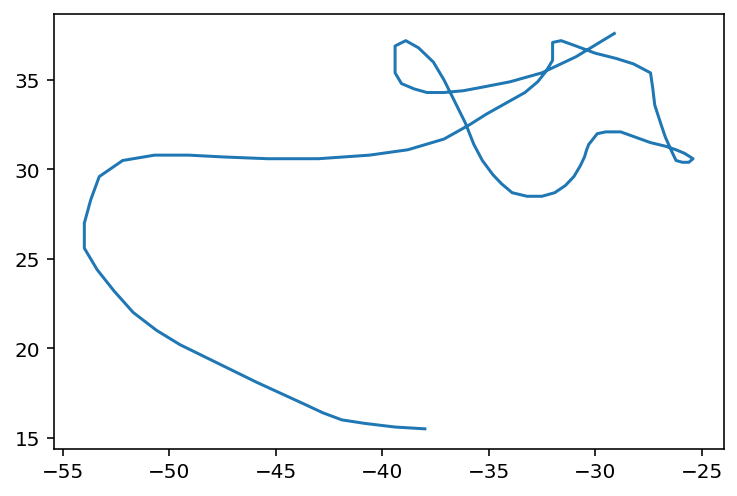

In [122]:
j = hd.get(['key', 'Lat', 'Lon'])
nad = j.where(j['key'] == sorted.key[0], drop = True)
# lat = nad['Lat'].values
# lon = nad['Lon'].values
# lon = [x * -1 for x in lon]
# xpt

plt.plot(nad['Lon'].values, nad['Lat'].values)

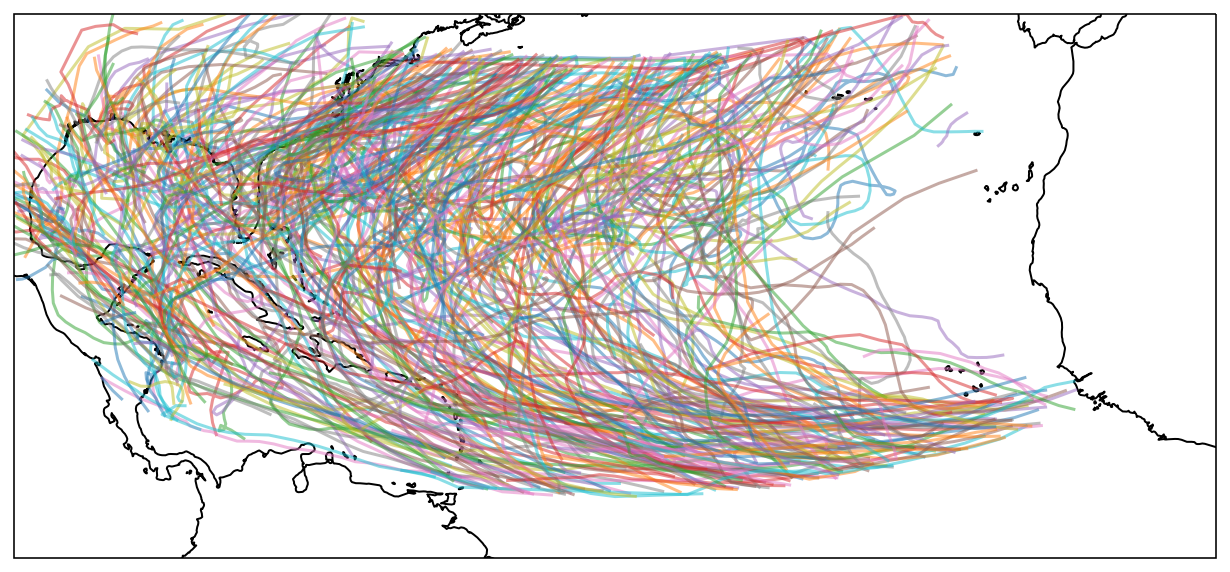

In [123]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

for i in range(0,481):
    th = j.where(j['key'] == sorted.key[i], drop = True)
    plt.plot(th['Lon'].values, th['Lat'].values, transform=proj_dta, alpha = 0.5)

ax.coastlines();
ax.set_extent(extent)

In [124]:
myindices = []

year = str(2005)
for i in range(len(hd['key'])):
    if hd['key'].values[i][-4:] == year:
        myindices.append(i)
            
lat05 = hd.Lat[myindices]
lon05 = hd.Lon[myindices]
key05 = hd.key[myindices]

myAr = np.array((key05, lat05, lon05))
myXr = xr.DataArray(myAr)
myXr

<xarray.DataArray (dim_0: 3, dim_1: 771)>
array([['             ARLENE2005', '             ARLENE2005',
        '             ARLENE2005', ..., '            EPSILON2005',
        '            EPSILON2005', '            EPSILON2005'],
       [16.9, 17.4, 18.2, ..., 31.1, 30.8, 30.1],
       [-84.0, -83.9, -83.9, ..., -52.5, -53.5, -54.2]], dtype=object)
Dimensions without coordinates: dim_0, dim_1

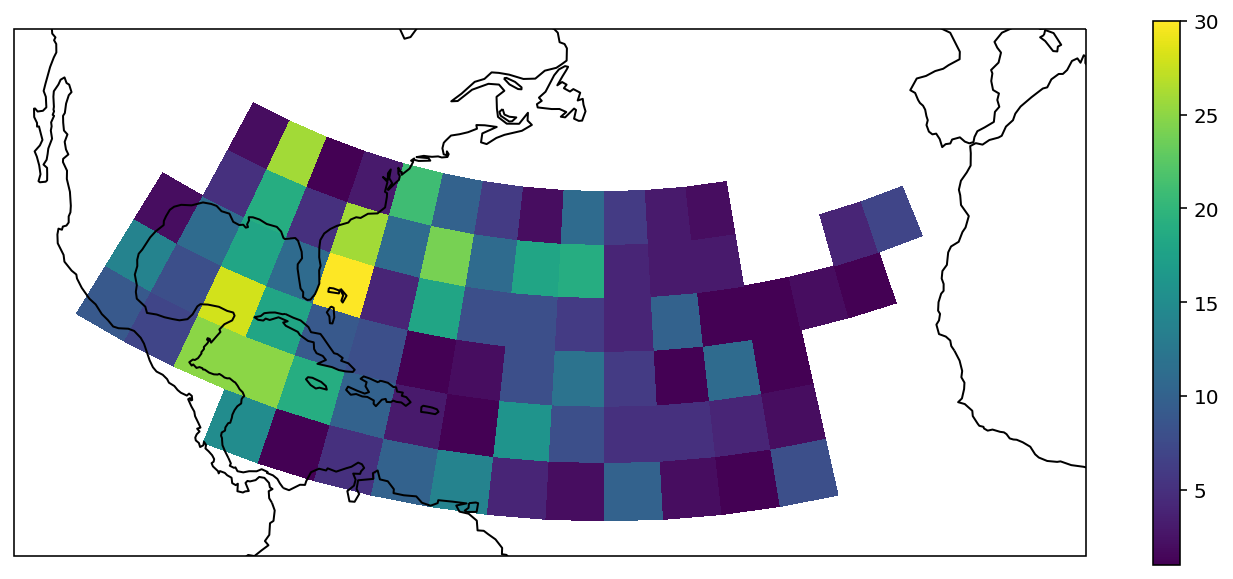

In [125]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize = (12,5))
ax = plt.subplot(projection = proj_map)

extent = [-100, -10, 5, 45]

D05 = hdpd['year'] == 2005 
X = np.arange(-100,-10, 5)
Y = np.arange(10, 45, 5)
H, xedges, yedges = np.histogram2d(hdpd['Lon'][D05], hdpd['Lat'][D05], bins = [X, Y])
H[H == 0 ] = np.nan

g = ax.pcolormesh(X, Y, H.T, transform = proj_dta)

# plt.plot(-hdpd['Lon'][D05], hdpd['Lat'][D05], transform=proj_dta, linewidth = 6, alpha = 0.5)

ax.coastlines();
ax.set_extent(extent)
plt.colorbar(g)

In [126]:
xr05 = pd.DataFrame.to_xarray(hdpd[D05])

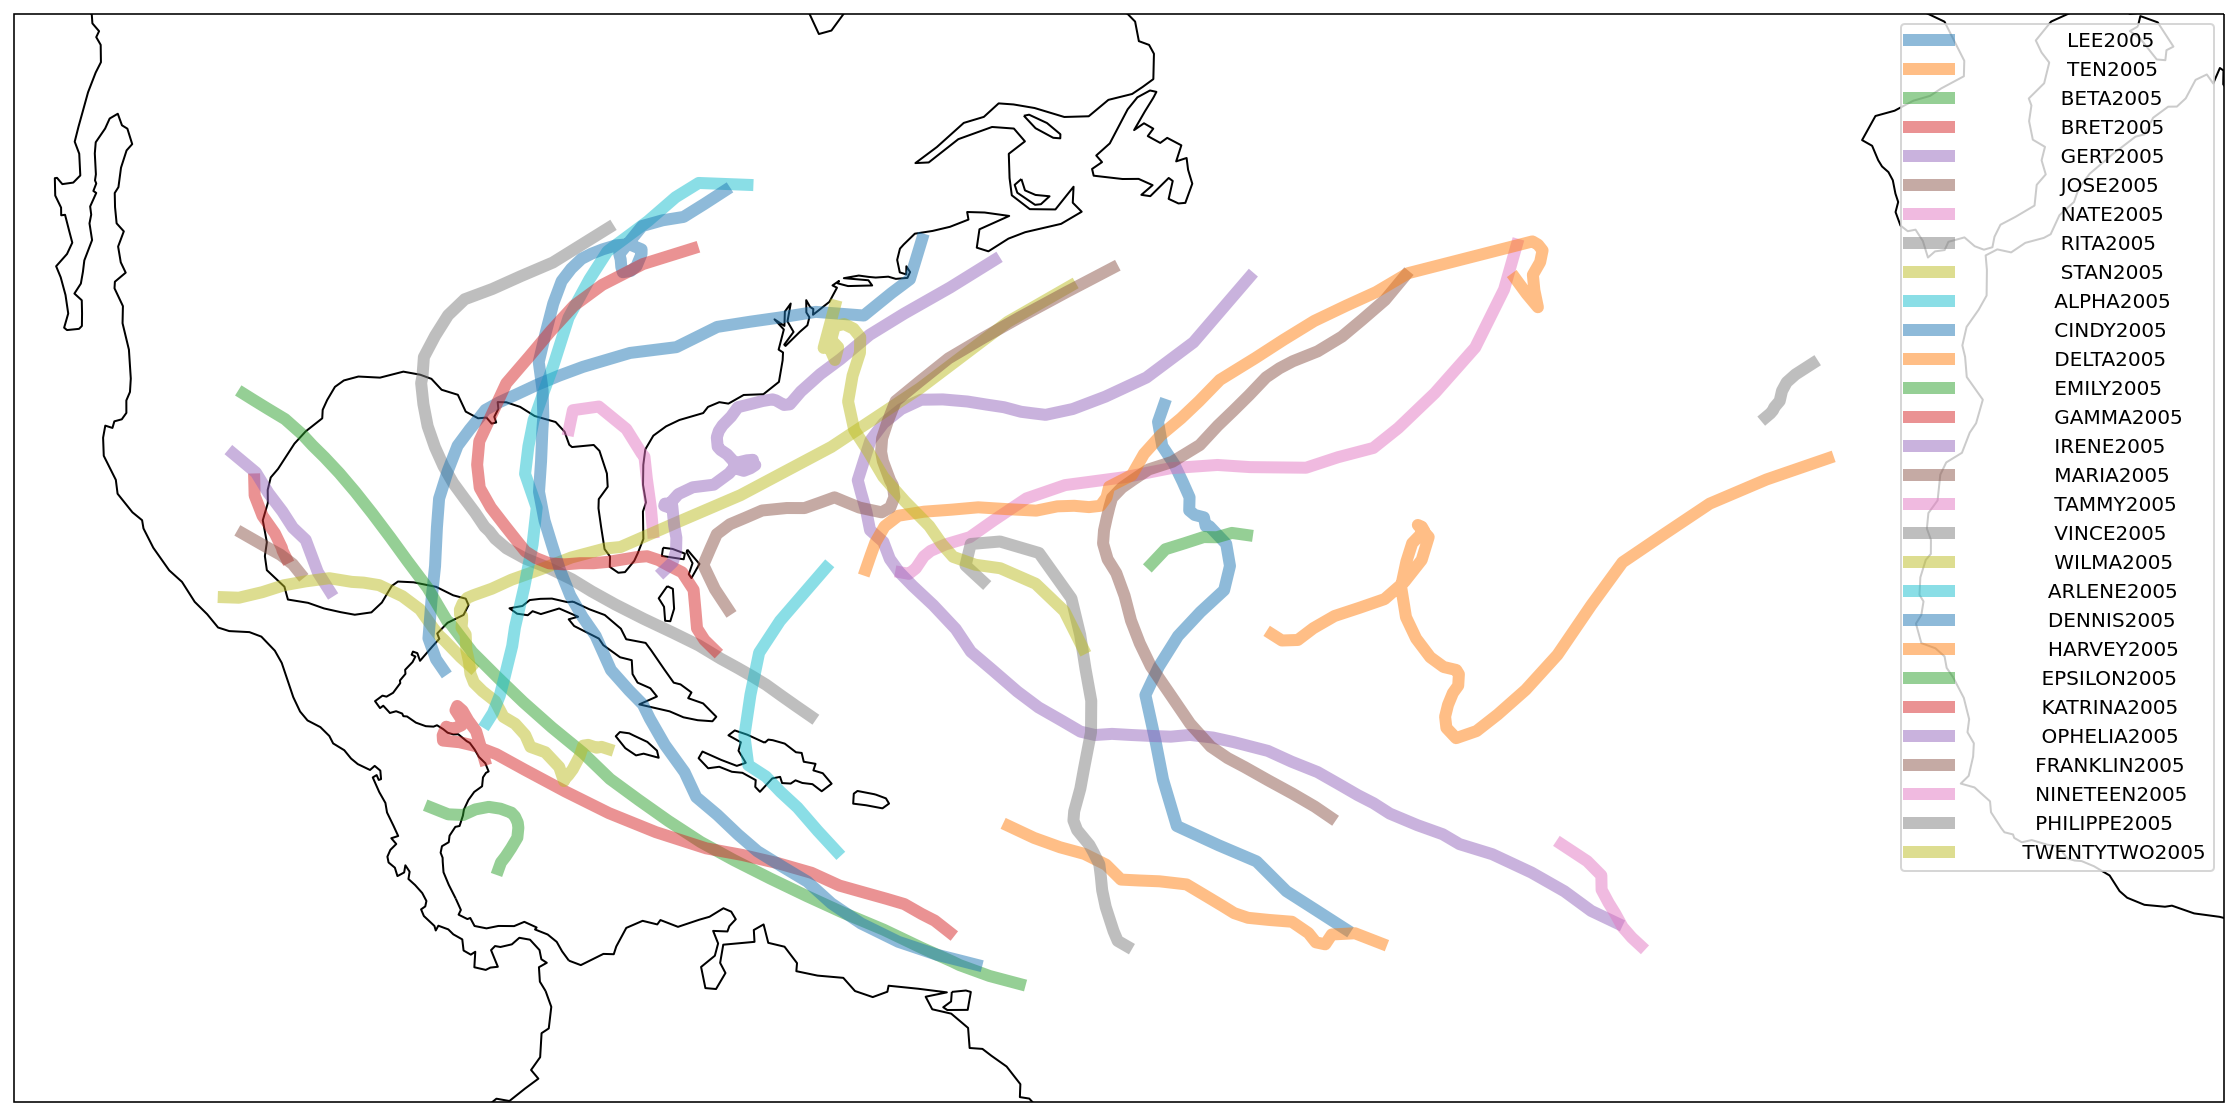

In [127]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize = (24,10))
ax = plt.subplot(projection = proj_map)

extent = [-100, -10, 5, 45]

for i in xr05.groupby('key').count().key:
    pt = xr05.where(xr05['key'] == i, drop = True)
    plt.plot(pt['Lon'].values, pt['Lat'].values, transform=proj_dta, linewidth = 6, alpha = 0.5, label = i.values)
    
ax.coastlines();
ax.set_extent(extent)
ax.legend()

In [128]:
allkeys = hd.groupby('key').count().key.values

In [129]:
#I want a dataset with just year, key, landfall (T/F)

In [130]:
biglist = pd.DataFrame(columns = ['Year', 'Landfall', 'MaxSpeed', 'MinPres', 'key'], index = np.arange(0,len(allkeys)))

for key in range(len(allkeys)):
    
    #initialize values
    maxspeed = 0
    minpres = 99999
    year = allkeys[key][-4:]
    minTemp = 1000
    landfall = False
    thisHurr = hd.where(hd['key'] == allkeys[key], drop = True)
    
    #Get whether landfall
    for i in thisHurr['SST']:
        if i < minTemp:
            minTemp = i
    if minTemp == 0:
        landfall = True
        
    #Get max wind
    for j in thisHurr['Max wind']:
        if j.values > maxspeed:
            maxspeed = j.values
            
    #Get min pres
    for k in thisHurr['Min pres']:
        if k.values < minpres:
            minpres = k.values
            
    #Add to list
    biglist.loc[key] = [year, landfall, maxspeed, minpres, allkeys[key]]

In [131]:
yearcount = []
xar = xr.DataArray(biglist)

#Sort list and re-index
inOrder = biglist.sort_values('Year')
inOrder.index = np.arange(0,len(allkeys))

#individual yearly values for reg.
years = np.arange(1982, 2020)
for i in years:
    thisYearFalls = 0
    thisYearTot = 0
    thisYearFast = 0
    thisYearPres = 1100
    for j in range(len(inOrder)):
        
        #Check this year
        if inOrder.Year[j] == str(i):
            thisYearTot += 1
            
            #add up landfall count
            if inOrder.Landfall[j] != False:
                thisYearFalls += 1
                
            #Get max wind speed
            if inOrder.MaxSpeed[j] > thisYearFast:
                thisYearFast = inOrder.MaxSpeed[j]
                
            #Get min press
            if inOrder.MinPres[j] < thisYearPres and inOrder.MinPres[j] > 0:
                thisYearPres = inOrder.MinPres[j]
                
    #Put data in list
    yearcount.append([i, thisYearFast, thisYearPres, thisYearFalls / thisYearTot, thisYearTot])
    
#Create df with list data
resF = pd.DataFrame(yearcount, columns = ['Year','MaxSpeed', 'MinPress', 'Prop', 'Count'])

In [132]:
#Open Nino. Dont want to use aug/sep but will for now

n34_Sep_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Sep/dods'
n34_Sep_ds = xr.open_dataset(n34_Sep_url)
n34_Sep = n34_Sep_ds.n34_Sep - n34_Sep_ds.n34_Sep.mean('T')

# n34_Aug['T'].dt.year
preds = n34_Sep[2:-2].values
n34

<xarray.Dataset>
Dimensions:  (T: 490)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-16T12:00:00 ... 2020-10-16T12:00:00
Data variables:
    n34      (T) float64 0.03077 -0.07718 0.2592 ... -0.7893 -1.101 -1.574

In [133]:
n34 = xr.open_dataset('n34T.nc')
n34 = n34-n34.mean('T')
Jan = 1
Feb = 2
Mar = 3
Apr = 4
May = 5
Jun = 6
Jul = 7
Aug = 8
Sep = 9
Oct = 10
Nov = 11
Dec = 12
n34_Jan = n34.n34.where(n34['T'].dt.month == Jan, drop = True)
n34_Feb = n34.n34.where(n34['T'].dt.month == Feb, drop = True)
n34_Mar = n34.n34.where(n34['T'].dt.month == Mar, drop = True)
n34_Apr = n34.n34.where(n34['T'].dt.month == Apr, drop = True)
n34_May = n34.n34.where(n34['T'].dt.month == May, drop = True)
n34_Jun = n34.n34.where(n34['T'].dt.month == Jun, drop = True)
n34_Jul = n34.n34.where(n34['T'].dt.month == Jul, drop = True)
n34_Aug = n34.n34.where(n34['T'].dt.month == Aug, drop = True)
n34_Sep = n34.n34.where(n34['T'].dt.month == Sep, drop = True)
n34_Oct = n34.n34.where(n34['T'].dt.month == Oct, drop = True)
n34_Nov = n34.n34.where(n34['T'].dt.month == Nov, drop = True)
n34_Dec = n34.n34.where(n34['T'].dt.month == Dec, drop = True)

In [168]:
#Try starting year from November

cc2 = np.empty((4,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc2[0, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MaxSpeed'])
        cc2[1, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MinPress'])
        cc2[2, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Prop'])
        cc2[3, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Count'])
    else:
        cc2[0, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MaxSpeed'])
        cc2[1, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MinPress'])
        cc2[2, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Prop'])
        cc2[3, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Count'])

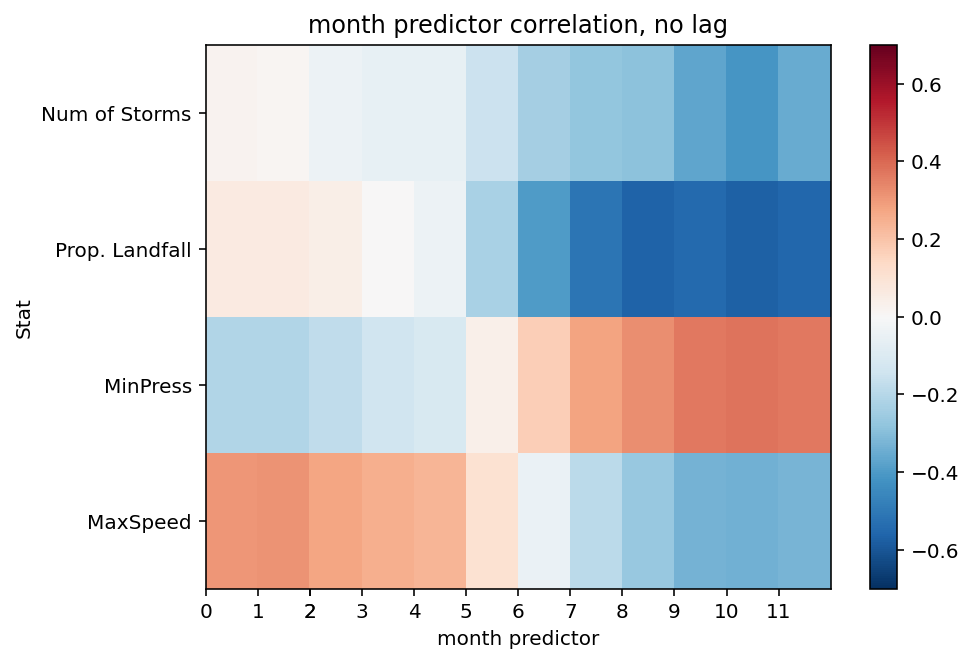

In [169]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 5) + 0.5, cc2, vmax=.7, vmin=-.7, cmap='RdBu_r')

ax.set_yticks(np.arange(1,5))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms'])
ax.set_xticks((np.arange(0,13)+2)%12)
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag');

In [170]:
cc = np.empty((4,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Count'])
    else:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Count'])

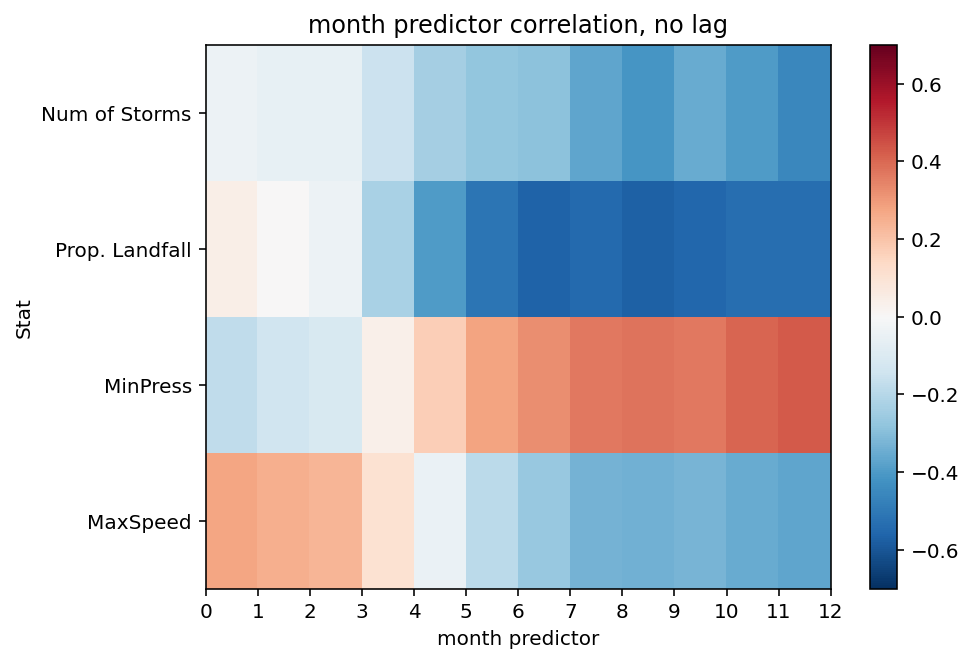

In [171]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 5) + 0.5, cc, vmax=.7, vmin=-.7, cmap='RdBu_r')

ax.set_yticks(np.arange(1,5))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag');

In [172]:
cc1 = np.empty((4,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc1[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['MaxSpeed'])
        cc1[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['MinPress'])
        cc1[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['Prop'])
        cc1[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['Count'])
    else:
        cc1[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MaxSpeed'])
        cc1[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MinPress'])
        cc1[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Prop'])
        cc1[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Count'])

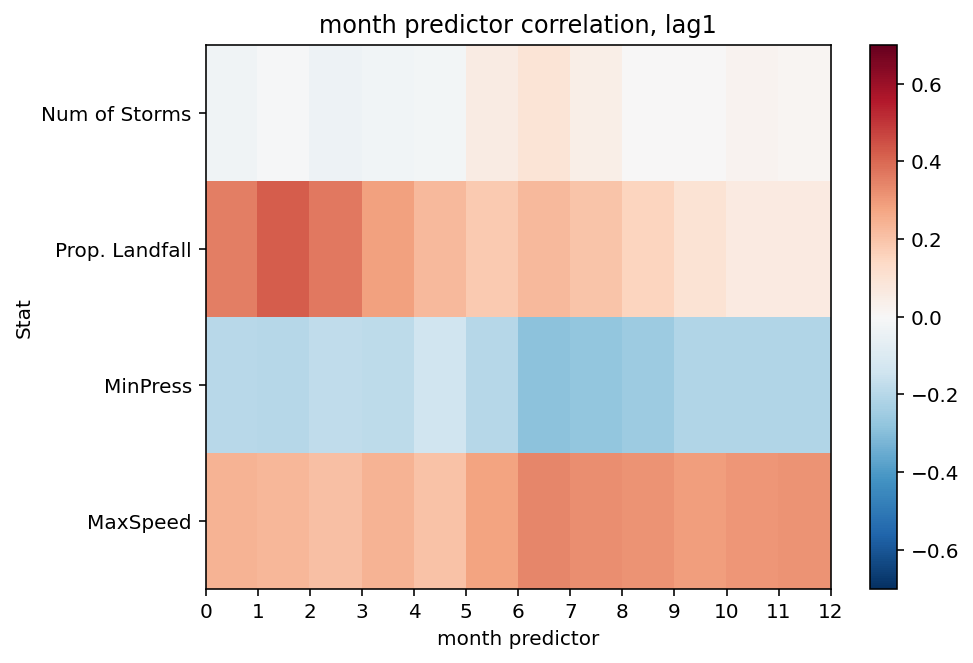

In [173]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 5) + 0.5, cc1, vmax=.7, vmin=-.7, cmap='RdBu_r')

ax.set_yticks(np.arange(1,5))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag1');

In [176]:
#Lag2

cc3 = np.empty((4,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Count'])
    else:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Count'])

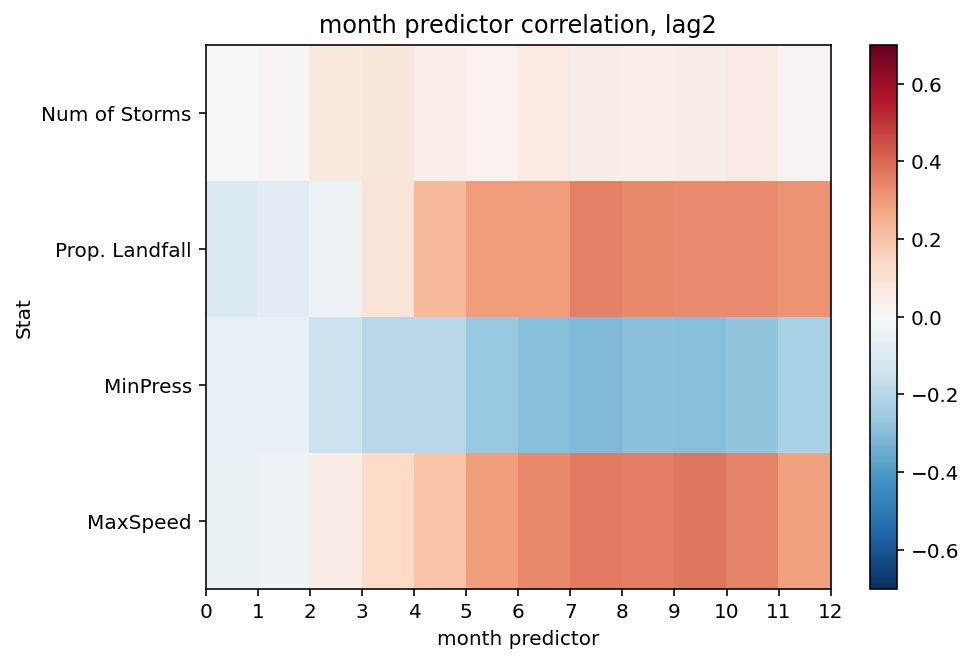

In [178]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 5) + 0.5, cc3, vmax=.7, vmin=-.7, cmap='RdBu_r')

ax.set_yticks(np.arange(1,5))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag2');

In [174]:
cc.min()

-0.5712484525402853

In [136]:
#Choose predictor
# preds = n34_Jul[2:-1]

In [137]:
#Let's get some correlations!!!
print("Correlation between April Nino and Landfall proportion: {}".format(cor(n34_Apr[2:-1], resF['Prop'].values)))
print("Correlation between May Nino and Landfall proportion: {}".format(cor(n34_May[2:-1], resF['Prop'].values)))
print("Correlation between June Nino and Landfall proportion: {}".format(cor(n34_Jun[2:-1], resF['Prop'].values)))
print("Correlation between July Nino and Landfall proportion: {}".format(cor(n34_Jul[2:-1], resF['Prop'].values)))
print()
print("Correlation between April Nino and Total Storms: {}".format(cor(n34_Apr[2:-1], resF['Count'].values)))
print("Correlation between May Nino and Total Storms: {}".format(cor(n34_May[2:-1], resF['Count'].values)))
print("Correlation between June Nino and Total Storms: {}".format(cor(n34_Jun[2:-1], resF['Count'].values)))
print("Correlation between July Nino and Total Storms: {}".format(cor(n34_Jul[2:-1], resF['Count'].values)))
print()
print("Correlation between April Nino and Max Wind Speed: {}".format(cor(n34_Apr[2:-1], resF['MaxSpeed'].values)))
print("Correlation between May Nino and MWS: {}".format(cor(n34_May[2:-1], resF['MaxSpeed'].values)))
print("Correlation between June Nino and MWS: {}".format(cor(n34_Jun[2:-1], resF['MaxSpeed'].values)))
print("Correlation between July Nino and MWS: {}".format(cor(n34_Jul[2:-1], resF['MaxSpeed'].values)))
print()
print("Correlation between April Nino and Min Pressure: {}".format(cor(n34_Apr[2:-1], resF['MinPress'].values)))
print("Correlation between May Nino and MP: {}".format(cor(n34_May[2:-1], resF['MinPress'].values)))
print("Correlation between June Nino and MP: {}".format(cor(n34_Jun[2:-1], resF['MinPress'].values)))
print("Correlation between July Nino and MP: {}".format(cor(n34_Jul[2:-1], resF['MinPress'].values)))

Correlation between April Nino and Landfall proportion: -0.22920171012302076
Correlation between May Nino and Landfall proportion: -0.3966295213492209
Correlation between June Nino and Landfall proportion: -0.5135451838265189
Correlation between July Nino and Landfall proportion: -0.567977006200729

Correlation between April Nino and Total Storms: -0.14780952235553318
Correlation between May Nino and Total Storms: -0.23630066613169218
Correlation between June Nino and Total Storms: -0.27544208374463275
Correlation between July Nino and Total Storms: -0.2856548303701467

Correlation between April Nino and Max Wind Speed: 0.10693080292156229
Correlation between May Nino and MWS: -0.04650722002105865
Correlation between June Nino and MWS: -0.18823448037293902
Correlation between July Nino and MWS: -0.2675711140599135

Correlation between April Nino and Min Pressure: 0.03831117505324151
Correlation between May Nino and MP: 0.17220264373334962
Correlation between June Nino and MP: 0.2828316

In [145]:
from numpy.linalg import inv

preds = n34_Jul[2:-1]


N = len(preds)

y = resF['Prop'].values

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta = inv(X.T@X)@X.T@y
# print(beta.shape)
yhat = X@beta
y

array([0.25      , 0.5       , 0.3       , 0.72727273, 0.5       ,
       0.16666667, 0.63636364, 0.36363636, 0.15384615, 0.42857143,
       0.33333333, 0.5       , 0.5       , 0.36842105, 0.53846154,
       0.14285714, 0.5       , 0.5       , 0.35714286, 0.4       ,
       0.58333333, 0.5       , 0.53333333, 0.51724138, 0.33333333,
       0.5625    , 0.58823529, 0.18181818, 0.47619048, 0.42105263,
       0.31578947, 0.35714286, 0.33333333, 0.16666667, 0.46666667,
       0.52941176, 0.3125    , 0.25      ])

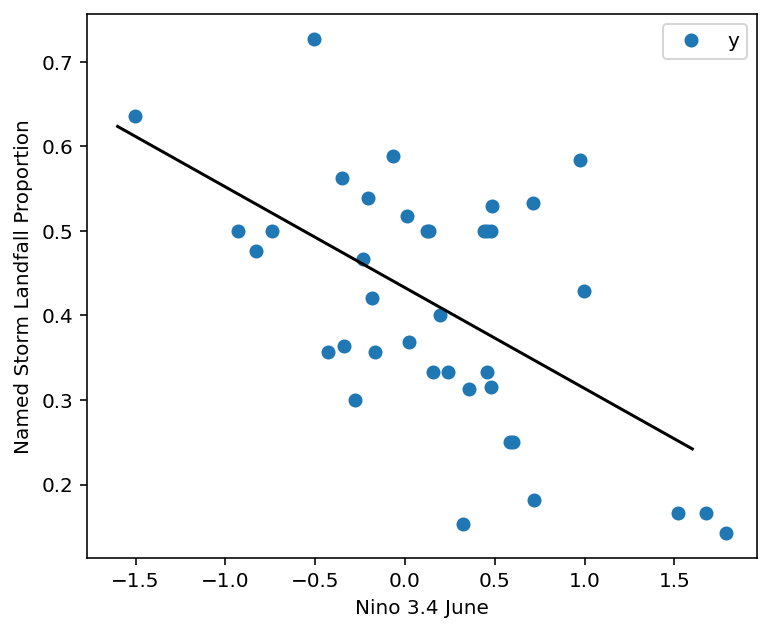

In [148]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');
# ax.plot(preds, yhat, 'o', label = 'yhat');

ax.set_xlabel('Nino 3.4 June')
ax.set_ylabel('Named Storm Landfall Proportion');

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

# for ii in range(0, N - 1):
#     ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k')
# ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k', label = 'residuals')
ax.legend();

In [140]:
ran = y.max()-y.min()
ran

0.5844155844155845

In [141]:
ynorm = (y-882)/ran
yhatnorm = (yhat-882)/ran
ynorm

array([-1508.77222222, -1508.34444444, -1508.68666667, -1507.95555556,
       -1508.34444444, -1508.91481481, -1508.11111111, -1508.57777778,
       -1508.93675214, -1508.46666667, -1508.62962963, -1508.34444444,
       -1508.34444444, -1508.56959064, -1508.27863248, -1508.95555556,
       -1508.34444444, -1508.34444444, -1508.58888889, -1508.51555556,
       -1508.20185185, -1508.34444444, -1508.28740741, -1508.31494253,
       -1508.62962963, -1508.2375    , -1508.19346405, -1508.88888889,
       -1508.38518519, -1508.47953216, -1508.65964912, -1508.58888889,
       -1508.62962963, -1508.91481481, -1508.40148148, -1508.29411765,
       -1508.66527778, -1508.77222222])

In [142]:
np.mean((ynorm-yhatnorm)**2)

0.040478856179096544

In [143]:
biglist.groupby('Year').count()

,Landfall,MaxSpeed,MinPres,key
Year,,,,
1982,4,4,4,4
1983,4,4,4,4
1984,10,10,10,10
1985,11,11,11,11
1986,6,6,6,6
1987,6,6,6,6
1988,11,11,11,11
1989,11,11,11,11
1990,13,13,13,13


In [144]:
xar

<xarray.DataArray (dim_0: 482, dim_1: 5)>
array([['1985', False, array(55.), array(996.),
        '                ANA1985'],
       ['1991', True, array(45.), array(1000.),
        '                ANA1991'],
       ['1997', False, array(40.), array(1000.),
        '                ANA1997'],
       ...,
       ['1995', False, array(55.), array(1001.),
        '          SEBASTIEN1995'],
       ['2019', False, array(60.), array(988.),
        '          SEBASTIEN2019'],
       ['2005', False, array(40.), array(1005.),
        '         TWENTYTWO2005']], dtype=object)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 ... 474 475 476 477 478 479 480 481
  * dim_1    (dim_1) object 'Year' 'Landfall' 'MaxSpeed' 'MinPres' 'key'